# Part 2 - Data analysis

# Context
Uber’s Driver team is interested in predicting which driver signups are most likely to
start driving. To help explore this question, we have provided a
**sample1 dataset of a cohort of driver signups in January 2015**.
The data was pulled a few months after they signed up to include the
result of whether they actually completed their first trip.
It also includes several pieces of background information gather about the driver and their car.

We would like you to use this data set to help understand what factors are best at predicting whether
a signup will start to drive, and offer suggestions to operationalize those insights to help Uber.

See below for a detailed description of the dataset. Please include any code you wrote for the analysis
and delete the dataset when you have finished with the challenge. Please also call out any data related
assumptions or issues that you encounter.

# Question
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis
(a few sentences/plots describing your approach will suffice). **What fraction of the driver signups took a first trip?**

2. **Build a predictive model to help Uber determine whether or not a driver signup will start driving**.
Discuss why you chose your approach, what alternatives you considered, and any concerns you have.
How valid is your model? Include any key indicators of model performance.

3. Briefly discuss **how Uber might leverage the insights gained from the model to generate more first trips**
(again, a few ideas/sentences will suffice).

# Data
```python
id: driver_id
city_id: city_id this user signed up in
signup_os: signup device of the user (“android”, “ios”, “website”, “other”)
signup_channel: what channel did the driver sign up from (“offline”, “paid”, “organic”, “referral”)
signup_timestamp: timestamp of account creation; local time in the form ‘YYYY-MM-DD’
bgc_date: date of background check consent; in the form ‘YYYY-MM-DD’
vehicle_added_date: date when driver’s vehicle information was uploaded; in the form ‘YYYY-MM-DD’
first_completed_date: date of the first trip as a driver; in the form ‘YYYY-MM-DD’
vehicle_make: make of vehicle uploaded (i.e. Honda, Ford, Kia)
vehicle_model: model of vehicle uploaded (i.e. Accord, Prius, 350z)
vehicle_year: year that the car was made; in the form ‘YYYY’
```

# Solution
## Load necessary packages and the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from dtreeviz.trees import dtreeviz
from pdpbox import pdp, info_plots

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn import tree

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('data/ds_challenge_v2_1_data.csv',
                 index_col=['id'],
                 parse_dates=['signup_date', 'bgc_date', 'vehicle_added_date', 'first_completed_date'])

In [2]:
df.head()

,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date
id,,,,,,,,,,
1,Strark,ios web,Paid,2016-01-02,NaT,NaT,NaN,NaN,NaN,NaT
2,Strark,windows,Paid,2016-01-21,NaT,NaT,NaN,NaN,NaN,NaT
3,Wrouver,windows,Organic,2016-01-11,2016-01-11,NaT,NaN,NaN,NaN,NaT
4,Berton,android web,Referral,2016-01-29,2016-02-03,2016-02-03,Toyota,Corolla,2016.0,2016-02-03
5,Strark,android web,Referral,2016-01-10,2016-01-25,2016-01-26,Hyundai,Sonata,2016.0,NaT


## EDA and Data Cleaning
Summary:
- Records with dates that do not follow the rules are removed:
  - Signups must happen first
  - Drivers can drive only after finishing their signup, background check and adding their vehicles.

In [3]:
# Size of data
print('Size of Data:', df.shape)
print('')

# Null and unique values
summary = pd.DataFrame({'Column Types': df.dtypes,
                        'Number of Nulls': df.isna().sum(),
                        'Unique Values': df.nunique()})
print(summary)

# Make sure the IDs are unique
print('The IDs are unique:', df.index.nunique() == len(df.index))

Size of Data: (54681, 10)

                        Column Types  Number of Nulls  Unique Values
city_name                     object                0              3
signup_os                     object             6857              5
signup_channel                object                0              3
signup_date           datetime64[ns]                0             30
bgc_date              datetime64[ns]            21785             74
vehicle_added_date    datetime64[ns]            41547             78
vehicle_make                  object            41458             46
vehicle_model                 object            41458            368
vehicle_year                 float64            41458             24
first_completed_date  datetime64[ns]            48544             57
The IDs are unique: True


In [4]:
# Check out the few categorical columns with few categories
# The other two features, vehicle model/make, have too many categories to check for errors for this challenge
cols = ['city_name', 'signup_os', 'signup_channel']
for col in cols:
    print(col)
    print(df[col].value_counts())
    print()

city_name
Strark     29557
Berton     20117
Wrouver     5007
Name: city_name, dtype: int64

signup_os
ios web        16632
android web    14944
windows         6776
mac             5824
other           3648
Name: signup_os, dtype: int64

signup_channel
Paid        23938
Referral    17316
Organic     13427
Name: signup_channel, dtype: int64



In [5]:
# Check out the few date columns
cols = ['signup_date', 'bgc_date', 'vehicle_added_date', 'first_completed_date']
for col in cols:
    print('{}: from {} to {}'.format(col, df[col].min().date(), df[col].max().date()))


signup_date: from 2016-01-01 to 2016-01-30
bgc_date: from 2016-01-01 to 2016-03-25
vehicle_added_date: from 2016-01-01 to 2016-03-26
first_completed_date: from 2016-01-04 to 2016-02-29


In [6]:
# A few sanitary checks on dates
print('Instances where signup_date > bgc_date:', (df['signup_date']>df['bgc_date']).sum())
print('Instances where signup_date > vehicle_added_date:', (df['signup_date']>df['vehicle_added_date']).sum())
print('Instances where signup_date > first_completed_date:', (df['signup_date']>df['first_completed_date']).sum())
print('Instances where vehicle_added_date > first_completed_date:', (df['vehicle_added_date']>df['first_completed_date']).sum())
print('Instances where bgc_date > first_completed_date:', (df['bgc_date']>df['first_completed_date']).sum())

Instances where signup_date > bgc_date: 0
Instances where signup_date > vehicle_added_date: 1
Instances where signup_date > first_completed_date: 0
Instances where vehicle_added_date > first_completed_date: 54
Instances where bgc_date > first_completed_date: 33


In [7]:
# Let remove rows that violate the above rules
df = df[-(df['signup_date']>df['vehicle_added_date'])][
    -(df['vehicle_added_date']>df['first_completed_date'])][
    -(df['bgc_date']>df['first_completed_date'])]

## Q1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis
(a few sentences/plots describing your approach will suffice). **What fraction of the driver signups took a first trip?**

Approach:
- Clean up records that do not follow the date rules above
- Calculate the **ratio** of the **number of records that have a first completed date** to the
**total number of records** in the table.

In [8]:
ratio = df['first_completed_date'].notna().sum()/len(df)
print('{:.2%} of the driver signups took a first trip'.format(ratio))

11.10% of the driver signups took a first trip


## Q2. Build a predictive model to help Uber determine whether or not a driver signup will start driving.
Discuss why you chose your approach, what alternatives you considered, and any concerns you have.
How valid is your model? Include any key indicators of model performance.

Solution:
- Feature Engineering:
  - Get day of the week of the signup, the number of days between signups and adding a vehicle, the number of days between signups and the background check
  - Fill nulls with -1/Unknown
  - Create dummy variables for categorical variables
- Modeling:
  - At first, I chose Random Forest, because it usually works quite well out of the box. It deals extremely well with correlated variables,
  and works well in high dimensions and requires minimum time to be optimized.
  - However, **Decision Tree actually outperformed Random Forest in this challenge**, meaning that many variables
  are just noise and do not have any predictive power. As a result, I plotted the decision tree(let's call it Decision Tree A).
  An interesting remark here:
    - If a user does add a vehicle after the signup, the sooner it happens, the more likely it will start to drive.(the whole right branch, and -1 means a user doesn't add any vehicle)
![treeA](images/treeA.svg)
  - Then I **dropped variables that can be known only after signups**(i.e. background check and adding vehicles), I fitted
    another Random Forest(B) and Decision Tree(B). The decision tree B learned nothing from the data (considering the AUC of 0.5).
    However, Random Forest B did give us a better-than-random-chance performance. Its PDP plots reveal a few interesting insights:
    - Signups in **Wrouver** are 5% less likely to start driving.
    - Signups with an **unknown OS** are 40% less likely to start driving. Are they from bot traffic or users with questionable intents?
    - **Web signups** are also less likely to start driving by a 5% margin. Are there any UX/UI issues that make it harder to do BG checks/add vehicles/etc?
    - **Referrals** perform much better than the signups from other channels. However, paid channels are doing the worst.
    - **Weekend traffic** is also slightly less likely to start driving. Perhaps they sign up on a whimp.
  - To summary, if we have access to user behavior data(e.g. how long it takes for them to add vehicles), the Decision Tree A model does a good job
  with a test accuracy of 93.65% and AUC of 90.47%. However, if we want to predict whether they are going to drive with barely their
  data available upon the sign ups, we can use Random Forest B, which has an accuray of 70.35% and AUC of 68.27%.


In [9]:
# Prepare training data
df['signup_day_of_week'] = df['signup_date'].dt.day_of_week.fillna(-1)
df['days_between_bgc_signup'] = (df['bgc_date'] - df['signup_date']).dt.days.fillna(-1)
df['days_between_add_vehicle_signup'] = (df['vehicle_added_date'] - df['signup_date']).dt.days.fillna(-1)
df['vehicle_year'] = df['vehicle_year'].fillna(-1)
df = df.fillna('Unknown')

# Keep columns of interest
cols_x = ['city_name', 'signup_os', 'signup_channel', 'vehicle_year', 'vehicle_model']
cols_x += ['signup_day_of_week', 'days_between_bgc_signup', 'days_between_add_vehicle_signup']

# Get dummy variables
x = pd.get_dummies(df[cols_x])
y = df['first_completed_date'] != 'Unknown'

In [10]:
# A model evaluation helper function
def model_pipeline(model, x, y):
    # Split training and test data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

    # Fit the model
    model.fit(x_train, y_train)

    # Performance metrics
    print(model)
    print()
    print('Dummy Test Accuracy: {:.2%}'.format(accuracy_score(y_test, [0] * len(y_test))))
    print('Training Accuracy: {:.2%}'.format(accuracy_score(y_train, model.predict(x_train))))
    print('Test Accuracy: {:.2%}'.format(accuracy_score(y_test, model.predict(x_test))))

    print('Dummy Test AUC: {:.2%}'.format(roc_auc_score(y_test, [0] * len(y_test))))
    print('Training AUC: {:.2%}'.format(roc_auc_score(y_train, model.predict(x_train))))
    print('Test AUC: {:.2%}'.format(roc_auc_score(y_test, model.predict(x_test))))

    plot_confusion_matrix(model, x_train, y_train)
    plot_confusion_matrix(model, x_test, y_test)

    return model, x_train, x_test, y_train, y_test

RandomForestClassifier(class_weight='balanced', n_jobs=-1)

Dummy Test Accuracy: 88.96%
Training Accuracy: 99.47%
Test Accuracy: 93.37%
Dummy Test AUC: 50.00%
Training AUC: 98.98%
Test AUC: 86.11%


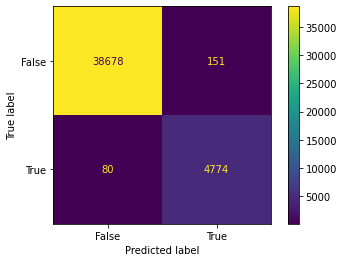

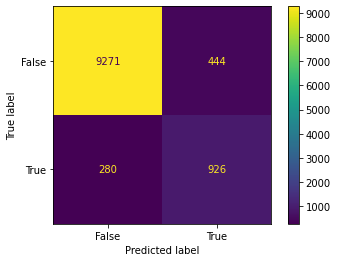

In [11]:
# Random Forest A
model = RandomForestClassifier(n_estimators=100,
                               class_weight='balanced',
                               n_jobs=-1)

model_rfa, x_train, x_test, y_train, y_test = model_pipeline(model, x, y)

DecisionTreeClassifier(max_depth=3, min_impurity_split=0.001)

Dummy Test Accuracy: 88.96%
Training Accuracy: 94.08%
Test Accuracy: 93.65%
Dummy Test AUC: 50.00%
Training AUC: 90.74%
Test AUC: 90.47%


'/var/folders/68/j99s1lkj7qz5ztbjt3fvh7cw0000gn/T/DTreeViz_42248.svg'

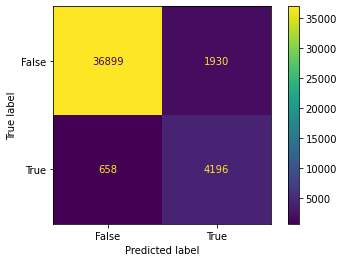

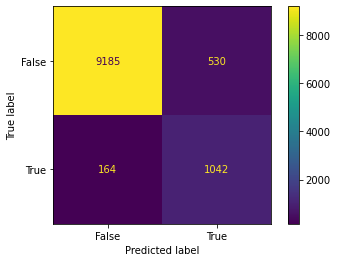

In [12]:
# Decision Tree A
model = tree.DecisionTreeClassifier(max_depth=3,
                                    min_impurity_split=0.001)

model_dta, x_train, x_test, y_train, y_test = model_pipeline(model, x, y)

viz = dtreeviz(model,
               x_test,
               y_test,
               target_name='signup',
               feature_names=x.columns)

viz.save_svg()

RandomForestClassifier(class_weight='balanced', n_jobs=-1)

Dummy Test Accuracy: 88.96%
Training Accuracy: 70.51%
Test Accuracy: 70.35%
Dummy Test AUC: 50.00%
Training AUC: 68.95%
Test AUC: 68.27%


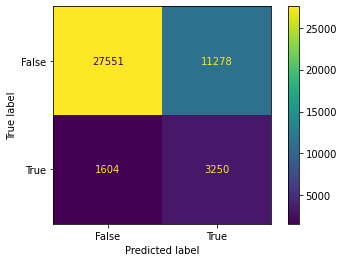

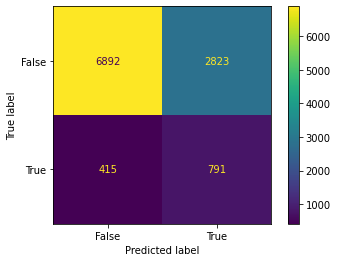

In [13]:
# Random Forest B
# Get variables that can be known on the signup day
cols_x = ['city_name', 'signup_os', 'signup_channel', 'signup_day_of_week']

model = RandomForestClassifier(n_estimators=100,
                               class_weight='balanced',
                               n_jobs=-1)

model_rfb, x_train, x_test, y_train, y_test = model_pipeline(model, pd.get_dummies(df[cols_x]), y)

DecisionTreeClassifier(max_depth=3, min_impurity_split=0.001)

Dummy Test Accuracy: 88.96%
Training Accuracy: 88.89%
Test Accuracy: 88.96%
Dummy Test AUC: 50.00%
Training AUC: 50.00%
Test AUC: 50.00%


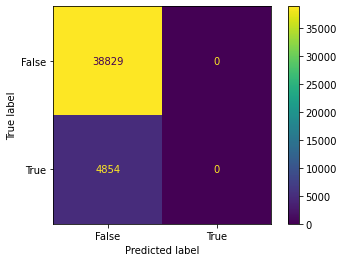

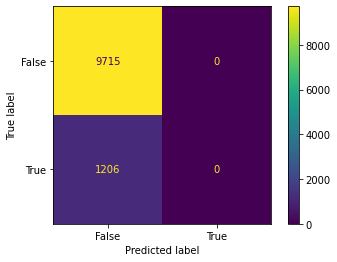

In [14]:
# Decision Tree B
# Get variables that can be known on the signup day
cols_x = ['city_name', 'signup_os', 'signup_channel', 'signup_day_of_week']
x = pd.get_dummies(df[cols_x])

model = tree.DecisionTreeClassifier(max_depth=3,
                                    min_impurity_split=0.001)

model_dtb, x_train, x_test, y_train, y_test = model_pipeline(model, pd.get_dummies(df[cols_x]), y)

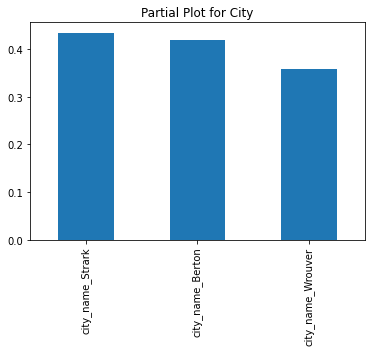

In [15]:
# PDP Plot for Random Forest B - City
x_reduced = pd.get_dummies(df[cols_x])
pdp_iso = pdp.pdp_isolate(model=model_rfb,
                          dataset=x_reduced,
                          model_features=x_reduced.columns,
                          feature=['city_name_Berton', 'city_name_Strark', 'city_name_Wrouver'],
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Partial Plot for City')
plt.show()

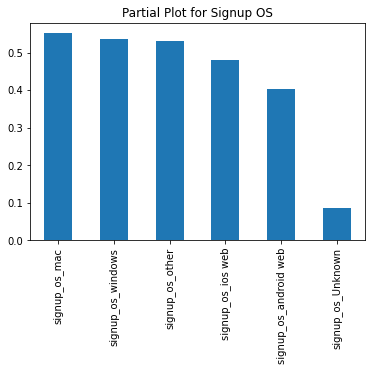

In [18]:
# PDP Plot for Random Forest B - Signup OS
pdp_iso = pdp.pdp_isolate(model=model_rfb,
                          dataset=x_reduced,
                          model_features=x_reduced.columns,
                          feature=['signup_os_Unknown', 'signup_os_android web', 'signup_os_ios web',
                                   'signup_os_mac', 'signup_os_other', 'signup_os_windows'],
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Partial Plot for Signup OS')
plt.show()

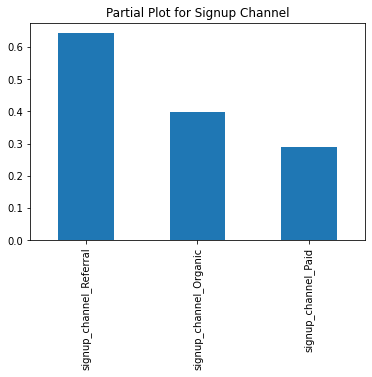

In [19]:
# PDP Plot for Random Forest B - Signup Channel
pdp_iso = pdp.pdp_isolate(model=model_rfb,
                          dataset=x_reduced,
                          model_features=x_reduced.columns,
                          feature=['signup_channel_Organic', 'signup_channel_Paid', 'signup_channel_Referral'],
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Partial Plot for Signup Channel')
plt.show()

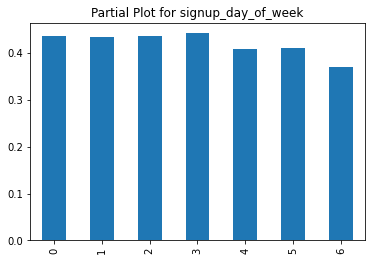

In [21]:
# PDP Plot for Random Forest B - Day of the week
pdp_iso = pdp.pdp_isolate(model=model_rfb,
                          dataset=x_reduced,
                          model_features=x_reduced.columns,
                          feature='signup_day_of_week',
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.plot(kind='bar', title='Partial Plot for signup_day_of_week')
plt.show()

## Q3. Briefly discuss **how Uber might leverage the insights gained from the model to generate more first trips**

- **Prompt signups to add their vehicle as soon as possible**, and streamline the UI/UX so they can be done quick and easily.
If they are done within 2 weeks, they have an at least 50% chance of starting driving. After that the chance drops pretty quickly.
- The same goes for the **background check**. It should not take long for their check to complete (on Uber's side); otherwise they may lose patience.
- Try to get **more signups in Strark and Berton** (assume the marketing cost per signup is the same) because their signups are more likely to drive.
- Look into the **mobile web app** as there is likely a **UI/UX issue** that is dragging the first trips down. Try to fix/improve it and then
conduct an AB test to see if that helps.
- Look into **signups from an unknown OS**. If they are not bots, we can try to improve the UI/UX on their OS.
- **Allocate more money to the referral program and SEO** and less to paid channels, which are under-performing and need investigation.
- **Show Ads/send emails to potential signups on the weekdays** rather than on the weekends.